In [95]:
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit import RDConfig
from rdkit.Geometry import Point3D
import numpy as np

In [2]:
# Open and read the text file
with open('..\\..\\..\\..\\7-Docking HD score migliori\\240731_Top10PercentSelection\\2-fredHD_corretto\\OK_C1_Top10Percent_dockHD.sdf\\OK_C1_Top10Percent_dockHD.sdf', 'r') as file:
    # Read the content of the file
    content = file.read()

# Split the content by the delimiter '$$$$'
blocks = content.split('$$$$')

In [3]:
pose_index = [molecule.split("Pose Index>")[-1] for molecule in blocks]
pose_index2 = [string.replace('\n', '') for string in pose_index]
pose_index2

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '1',
 '2',
 '3',
 '4',


In [11]:
C1_sdf_top10 = pd.DataFrame(blocks, columns=["molecule"])
C1_sdf_top10

,molecule
0,molecule_1\n -OEChem-08262401583D\n\n 42 44 ...
1,\nmolecule_1\n -OEChem-08262401583D\n\n 42 44...
2,\nmolecule_1\n -OEChem-08262401583D\n\n 42 44...
3,\nmolecule_1\n -OEChem-08262401583D\n\n 42 44...
4,\nmolecule_1\n -OEChem-08262401583D\n\n 42 44...
...,...
475766,\nmolecule_47574\n -OEChem-08272403513D\n\n 2...
475767,\nmolecule_47574\n -OEChem-08272403513D\n\n 2...
475768,\nmolecule_47574\n -OEChem-08272403513D\n\n 2...
475769,\nmolecule_47574\n -OEChem-08272403513D\n\n 2...


In [12]:
C1_sdf_top10["pose_index"] = pose_index2
C1_sdf_top10

,molecule,pose_index
0,molecule_1\n -OEChem-08262401583D\n\n 42 44 ...,1
1,\nmolecule_1\n -OEChem-08262401583D\n\n 42 44...,2
2,\nmolecule_1\n -OEChem-08262401583D\n\n 42 44...,3
3,\nmolecule_1\n -OEChem-08262401583D\n\n 42 44...,4
4,\nmolecule_1\n -OEChem-08262401583D\n\n 42 44...,5
...,...,...
475766,\nmolecule_47574\n -OEChem-08272403513D\n\n 2...,7
475767,\nmolecule_47574\n -OEChem-08272403513D\n\n 2...,8
475768,\nmolecule_47574\n -OEChem-08272403513D\n\n 2...,9
475769,\nmolecule_47574\n -OEChem-08272403513D\n\n 2...,10


,FRED Chemgauss4 score,CG3:Steric,CG3:Clash,CG3:ProDesolv,CG3:LigDesolv,CG3:LigDesolvHB,CG4:HB,Pose Index,ID,SMILES,Molecule
0,-12.782001,-17.560177,0.400870,5.121851,4.980977,-3.013647,-2.711874,1,molecule_1,[NH3+][C@@H](Cc1ccccc1)C(=O)N[C@@H]1CCc2cn[nH]...,
1,-12.639855,-17.508656,0.425916,5.057231,4.903502,-2.937858,-2.579992,2,molecule_1,[NH3+][C@@H](Cc1ccccc1)C(=O)N[C@@H]1CCc2cn[nH]...,
2,-12.500423,-12.698322,0.573578,3.264291,5.012974,-3.933437,-4.719508,3,molecule_1,[NH3+][C@@H](Cc1ccccc1)C(=O)N[C@@H]1CCc2cn[nH]...,
3,-12.356565,-17.350220,0.483890,5.475644,4.899558,-3.017615,-2.847823,4,molecule_1,[NH3+][C@@H](Cc1ccccc1)C(=O)N[C@@H]1CCc2cn[nH]...,
4,-12.341566,-13.869330,0.550906,3.568699,4.916535,-3.493864,-4.014513,5,molecule_1,[NH3+][C@@H](Cc1ccccc1)C(=O)N[C@@H]1CCc2cn[nH]...,
...,...,...,...,...,...,...,...,...,...,...,...
475765,-9.002725,-11.157941,0.362899,2.688474,5.023569,-3.086912,-2.832813,6,molecule_47574,NC(=O)C(=O)NCCNC(=O)CC(F)(F)F,
475766,-9.001410,-11.338198,0.260017,2.353821,5.256469,-3.173840,-2.359679,7,molecule_47574,NC(=O)C(=O)NCCNC(=O)CC(F)(F)F,
475767,-8.965244,-11.091215,0.379209,2.330574,4.970349,-2.982176,-2.571986,8,molecule_47574,NC(=O)C(=O)NCCNC(=O)CC(F)(F)F,
475768,-8.906229,-11.274338,0.293791,2.418689,4.815570,-3.492929,-1.667011,9,molecule_47574,NC(=O)C(=O)NCCNC(=O)CC(F)(F)F,

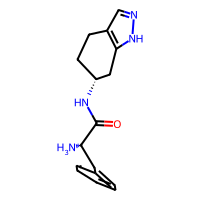
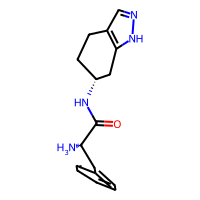
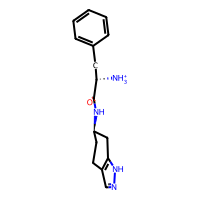
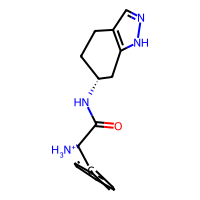
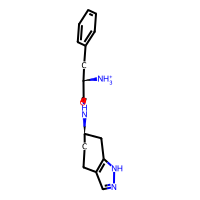
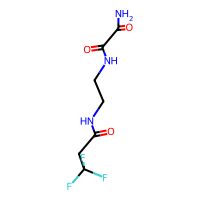
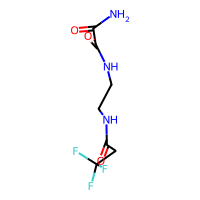
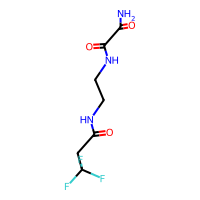
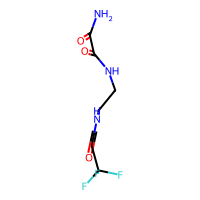
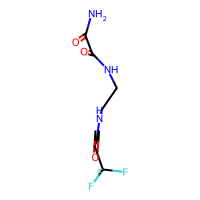

In [15]:
frame = PandasTools.LoadSDF('..\\..\\..\\..\\7-Docking HD score migliori\\240731_Top10PercentSelection\\2-fredHD_corretto\\OK_C1_Top10Percent_dockHD.sdf\\OK_C1_Top10Percent_dockHD.sdf',smilesName='SMILES',molColName='Molecule',includeFingerprints=True)
frame

In [ ]:
#creare l'array delle posizioni atomiche dei 10 conformeri con .GetPositions()
#sommare gli array e dividerli per 10 (media)
#fare così per ogni gruppo di 10 conformeri
#salvare l'array così ottenuto ogni volta: rappresenta l'average structure per la molecola n

In [20]:
for i in range(10):
    frame["Molecule"][i].GetConformer().GetPositions()

In [93]:
grouped = frame.groupby(frame.index // 10)
averages = []
for group_number, group in grouped:
    positions = []
    for i in range(10):
        coord = np.array(group["Molecule"].iloc[i].GetConformer().GetPositions())
        positions.append(coord)
    average = (positions[0]+positions[1]+positions[2]+positions[3]+positions[4]+positions[5]+positions[6]+positions[7]+positions[8]+positions[9])/10
    averages.append(average)
averages

[array([[68.32671, 80.67698, 47.63052],
        [68.90783, 80.37426, 46.98756],
        [67.70217, 80.87834, 47.28152],
        [68.86446, 80.2727 , 45.99582],
        [67.65882, 80.77679, 46.2898 ],
        [69.22011, 83.83655, 43.63782],
        [68.70625, 83.37532, 44.08485],
        [68.2399 , 80.47406, 45.64682],
        [69.32189, 82.99794, 43.3555 ],
        [68.27318, 81.35079, 44.47215],
        [67.73785, 83.26149, 45.09651],
        [69.13024, 82.43719, 43.42772],
        [67.45014, 82.72331, 45.07292],
        [68.21731, 82.29882, 44.57535],
        [68.19273, 80.36425, 44.57338],
        [67.8147 , 80.87255, 44.58075],
        [70.09278, 83.75872, 42.69622],
        [70.1342 , 83.24322, 42.54403],
        [67.90501, 81.79438, 44.62758],
        [68.05841, 80.81506, 44.02256],
        [68.89415, 81.33473, 44.27614]]),
 array([[68.32671, 80.67698, 47.63052],
        [68.90783, 80.37426, 46.98756],
        [67.70217, 80.87834, 47.28152],
        [68.86446, 80.2727 , 45.99582]

In [ ]:
  conf = mol.GetConformer()
  for i in range(mol.GetNumAtoms()):
     x,y,z = new_atom_ps[i]
     conf.SetAtomPosition(i,Point3D(x,y,z))

#df = pd.DataFrame({
    'A': range(1, 21),   # values from 1 to 20
    'B': range(101, 121) # values from 101 to 120
})

def multiply_by_two(x):
    return x * 2

# Group the data into chunks of 5 consecutive rows
grouped = df.groupby(df.index // 5)

# Loop through each group (chunk)
for group_number, group in grouped:
    # Select the 3rd row of each chunk (index 2, since it's 0-based)
    row_to_modify = group.iloc[2]

    # Apply the function to a single element of column 'A' in the selected row
    result = multiply_by_two(row_to_modify['A'])

    print(f"Chunk {group_number} - Original value: {row_to_modify['A']}, Modified value: {result}")